In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def remove_zeros_distribution(x):

    return [i for i in x if i != 0]

def log_binning_distribution(x_i, B = 20): 
    
    x_i = remove_zeros_distribution(x_i)

    b_1 = min(x_i)
    b_Bp1 = max(x_i)
    q_1 = np.log(b_1)
    q_Bp1 = np.log(b_Bp1)
    D_q = q_Bp1 - q_1
    L_q = D_q / B

    q_list = []
    b_list = []

    for i in range(B):
        j = i + 1
        q_list.append(q_1 + (j-1)*L_q)
        b_list.append(np.exp(q_1 + (j-1)*L_q))
   
    binned_x_i = []
    density_list = []

    for i in range(len(b_list)-1):
        bin_low = b_list[i]
        bin_high = b_list[i+1]
        count_bin = 0
        for j in range(len(x_i)):
            if x_i[j] >= bin_low and x_i[j] < bin_high:
                count_bin = count_bin + 1
                
        if count_bin > 0:
            density_bin = count_bin / (len(x_i)*(bin_high-bin_low))
            density_list.append(density_bin)
            binned_x_i.append(bin_low)
        else:
            continue 
            
    return binned_x_i, density_list

In [3]:
ddi = pd.read_csv('edge.csv.gz', compression='gzip',names=['node1','node2'])

In [4]:
ddi.head()

,node1,node2
0,4039,2424
1,4039,225
2,4039,3901
3,4039,223
4,4039,511


In [5]:
# Generate a synthetic graph for demonstration
# You can replace this with your own NetworkX graph
graph = nx.from_edgelist(list(zip(ddi['node1'],ddi['node2'])))
num_nodes = graph.number_of_nodes()

# Create positive and negative links for training and evaluation
edges = list(graph.edges)
non_edges = list(nx.non_edges(graph))
np.random.shuffle(edges)
np.random.shuffle(non_edges)

# Ensure an equal number of positive and negative samples
num_samples = min(len(edges), len(non_edges))
edges = edges[:num_samples]
non_edges = non_edges[:num_samples]

# Split data into train and test sets
train_edges, test_edges = train_test_split(edges, test_size=0.2, random_state=42)
train_non_edges, test_non_edges = train_test_split(non_edges, test_size=0.2, random_state=42)

# Convert graph data to PyTorch tensors
train_edges = torch.LongTensor(train_edges)
test_edges = torch.LongTensor(test_edges)
train_non_edges = torch.LongTensor(train_non_edges)
test_non_edges = torch.LongTensor(test_non_edges)

# Define a GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(GraphSAGE, self).__init__()
        self.embedding_dim = embedding_dim
        
        # Embedding layer
        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        
        # Aggregation layer
        self.aggregation = nn.Linear(embedding_dim * 2, embedding_dim)
        
    def forward(self, nodes, neighbor_nodes):
        # Node embeddings
        node_embeddings = self.embedding(nodes)
        
        # Neighbor embeddings
        neighbor_embeddings = self.embedding(neighbor_nodes)
        
        # Aggregate neighbor embeddings
        aggregated = torch.cat([node_embeddings, neighbor_embeddings], dim=-1)
        
        # Apply aggregation layer
        aggregated = self.aggregation(aggregated)
        
        return aggregated

# Define a decoder for binary classification
class LinkPredictionDecoder(nn.Module):
    def __init__(self, embedding_dim):
        super(LinkPredictionDecoder, self).__init__()
        self.fc = nn.Linear(embedding_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, embeddings):
        output = self.fc(embeddings)
        return self.sigmoid(output)

# Initialize the model, decoder, and optimizer
embedding_dim = 128
model = GraphSAGE(num_nodes, embedding_dim)
decoder = LinkPredictionDecoder(embedding_dim)
optimizer = optim.Adam(list(model.parameters()) + list(decoder.parameters()), lr=0.01)

# Training loop
num_epochs = 10
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    np.random.shuffle(train_edges)
    np.random.shuffle(train_non_edges)
    
    for i in tqdm(range(0, len(train_edges), batch_size)):
        batch_edges = train_edges[i:i+batch_size]
        batch_non_edges = train_non_edges[i:i+batch_size]
        
        # Positive samples
        pos_nodes = torch.cat([batch_edges[:, 0], batch_edges[:, 1]])
        pos_neighbors = torch.cat([batch_edges[:, 1], batch_edges[:, 0]])
        
        # Negative samples
        neg_nodes = torch.cat([batch_non_edges[:, 0], batch_non_edges[:, 1]])
        neg_neighbors = torch.cat([batch_non_edges[:, 1], batch_non_edges[:, 0]])
        
        # Forward pass through GraphSAGE
        pos_embeddings = model(pos_nodes, pos_neighbors)
        neg_embeddings = model(neg_nodes, neg_neighbors)
        
        # Forward pass through the decoder
        pos_output = decoder(pos_embeddings)
        neg_output = decoder(neg_embeddings)
        
        # Calculate loss
        labels = torch.cat([torch.ones(pos_output.size(0)), torch.zeros(neg_output.size(0))])
        logits = torch.cat([pos_output, neg_output]).squeeze()
        loss = nn.BCELoss()(logits, labels)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
decoder.eval()
test_pos_embeddings = model(test_edges[:, 0], test_edges[:, 1])
test_neg_embeddings = model(test_non_edges[:, 0], test_non_edges[:, 1])

# Forward pass through the decoder for test data
test_pos_output = decoder(test_pos_embeddings).detach().numpy()
test_neg_output = decoder(test_neg_embeddings).detach().numpy()

# Concatenate the predictions and true labels
predictions = np.concatenate([test_pos_output, test_neg_output])
true_labels = np.concatenate([np.ones_like(test_pos_output), np.zeros_like(test_neg_output)])

# Calculate ROC AUC and AP for binary classification
auc = roc_auc_score(true_labels, predictions)
ap = average_precision_score(true_labels, predictions)

print(f'Test AUC: {auc:.4f}')
print(f'Test AP: {ap:.4f}')


/home/chatterjee.ay/.conda/envs/topology/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
/home/chatterjee.ay/.conda/envs/topology/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13349/13349 [03:18<00:00, 67.17it/s]


Test AUC: 0.7523
Test AP: 0.6837


In [6]:
graph_train = nx.from_edgelist(train_edges.tolist())
graph_test = nx.from_edgelist(test_edges.tolist())

In [22]:
degree_dict = dict()
for node in tqdm(graph_train.nodes()):
    degree_dict[node] = graph_train.degree(node)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3069/3069 [00:00<00:00, 110211.98it/s]


In [20]:
test_df = pd.DataFrame()
test_df['node1'] = [x[0] for x in test_edges.tolist()] + [x[0] for x in test_non_edges.tolist()]
test_df['node2'] = [x[1] for x in test_edges.tolist()] + [x[1] for x in test_non_edges.tolist()]
test_df['labels'] = [x[0] for x in list(true_labels)]
test_df['pred'] = [x[0] for x in list(predictions)]

In [69]:
deg1 = []
deg2 = []
for index, row in tqdm(test_df.iterrows()):
    n1 = int(row['node1'])
    n2 = int(row['node2'])
    if n1 in degree_dict.keys():
        deg1.append(degree_dict[n1])
    else:
        deg1.append(0)
    if n2 in degree_dict.keys():
        deg2.append(degree_dict[n2])
    else:
        deg2.append(0)

427166it [00:23, 18472.80it/s]


In [70]:
test_df['d1'] = deg1
test_df['d2'] = deg2

In [71]:
test_df = test_df.drop_duplicates(['node1','node2'])

In [72]:
test_df_transductive = test_df[(test_df['d1'] != 'NA') & (test_df['d2'] != 'NA')]

In [73]:
print(min(test_df_transductive['d1'].tolist()+test_df_transductive['d2'].tolist()),max(test_df_transductive['d1'].tolist()+test_df_transductive['d2'].tolist()))

0 24


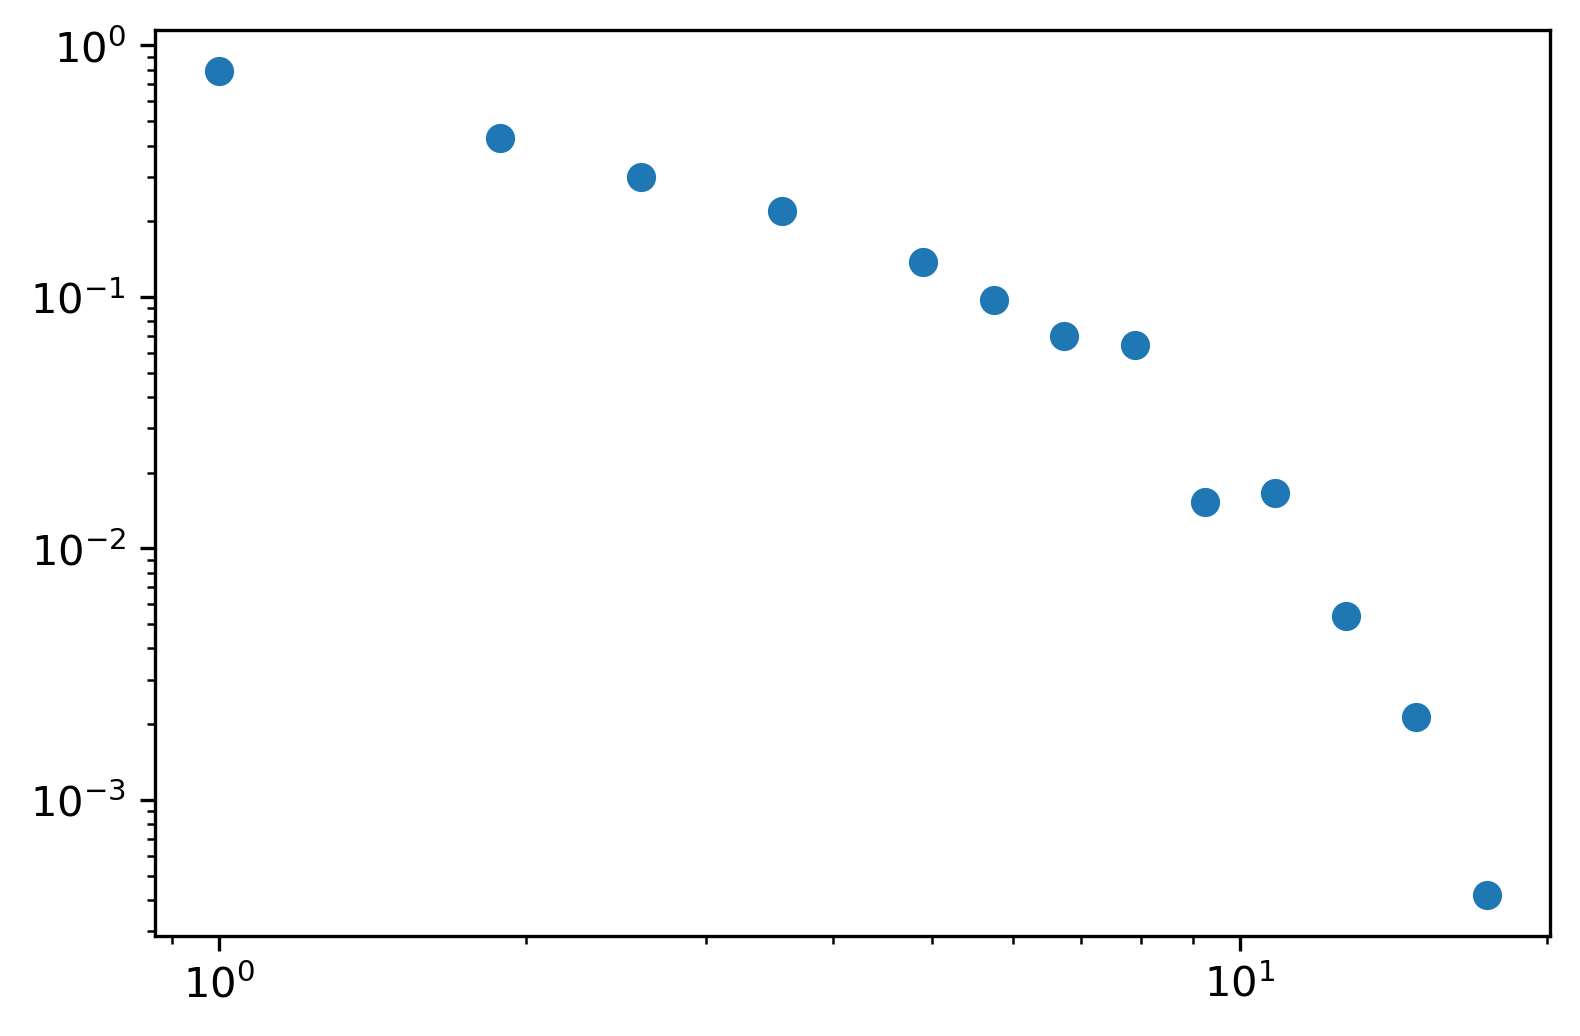

In [75]:
degree_list = list(test_df_transductive['d1'].tolist()+test_df_transductive['d2'].tolist())
binned_k, pdf = log_binning_distribution(degree_list, B = 20)
plt.figure(dpi=300)
plt.loglog(binned_k,pdf,'o')
plt.show()

In [78]:
test_df_transductive_zero_deg = test_df_transductive[(test_df_transductive['d1'] == 0) & (test_df_transductive['d2'] == 0)]

In [79]:
auc = roc_auc_score(test_df_transductive_zero_deg['labels'], test_df_transductive_zero_deg['pred'])
ap = average_precision_score(test_df_transductive_zero_deg['labels'], test_df_transductive_zero_deg['pred'])

print(f'Test AUC: {auc:.4f}')
print(f'Test AP: {ap:.4f}')

Test AUC: 0.5078
Test AP: 0.0426


In [80]:
test_df_transductive_low_deg = test_df_transductive[(test_df_transductive['d1'] == 1) & (test_df_transductive['d2'] == 1)]

In [81]:
auc = roc_auc_score(test_df_transductive_low_deg['labels'], test_df_transductive_low_deg['pred'])
ap = average_precision_score(test_df_transductive_low_deg['labels'], test_df_transductive_low_deg['pred'])

print(f'Test AUC: {auc:.4f}')
print(f'Test AP: {ap:.4f}')

Test AUC: 0.5514
Test AP: 0.3215


In [82]:
test_df_transductive_high_deg = test_df_transductive[(test_df_transductive['d1'] >= 2) | (test_df_transductive['d2'] >= 2)]

In [83]:
auc = roc_auc_score(test_df_transductive_high_deg['labels'], test_df_transductive_high_deg['pred'])
ap = average_precision_score(test_df_transductive_high_deg['labels'], test_df_transductive_high_deg['pred'])

print(f'Test AUC: {auc:.4f}')
print(f'Test AP: {ap:.4f}')

Test AUC: 0.7219
Test AP: 0.6944
